In [1]:
import numpy as np
import pandas as pd
from scipy import stats

#%matplotlib notebook
#%matplotlib ipympl

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Rejection Sampling

As a warmup, let's suppose that we want to sample a pair of random variables ($x_1$, $x_2$) drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below:

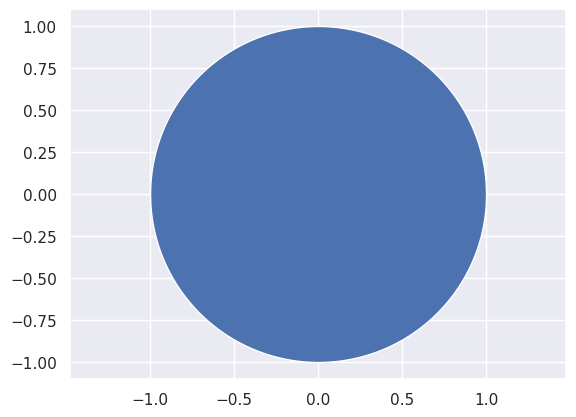

In [2]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.fill_between(x_, -semicircle, semicircle)
plt.axis('equal');

In [3]:

# Number of samples
N = 400

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])
samples

array([[ 0.2632026 ,  0.62580123],
       [ 0.77886121, -0.2294305 ],
       [ 0.48144089,  0.11822115],
       [ 0.83452706,  0.17935024],
       [-0.02211919, -0.57452872],
       [ 0.84457325, -0.19827711],
       [ 0.22807671, -0.40904087],
       [ 0.84618947, -0.02582746],
       [ 0.65042335,  0.47735804],
       [ 0.98753582,  0.06924559],
       [ 0.06022699,  0.85512788],
       [ 0.59353028, -0.90622359],
       [-0.32645497,  0.57271853],
       [-0.93294082, -0.66973261],
       [-0.75871219, -0.42121854],
       [-0.5560187 , -0.07161044],
       [ 0.79585636,  0.32457667],
       [-0.7268755 ,  0.00275387],
       [-0.43083881,  0.00578583],
       [-0.43866028,  0.76868386],
       [ 0.59398041, -0.13574804],
       [-0.10505284,  0.67479359],
       [-0.31455863,  0.81860882],
       [ 0.0689336 ,  0.82111027],
       [ 0.95056992, -0.68268209],
       [ 0.61273483, -0.92418887],
       [-0.70779635,  0.22823954],
       [-0.2878196 , -0.27765725],
       [-0.21173869,

Variance of x1 (estimated from samples): 0.236


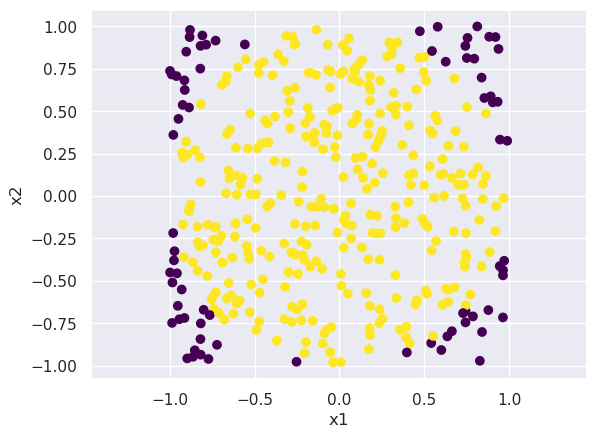

In [4]:

# Number of samples
N = 400

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=is_in_circle, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

Next, let's think about sampling from a distribution with a complicated density. Suppose we want to sample from the distribution with density $p(\theta|x) \propto \theta \cdot (1.5-\theta) \cdot \sin(\theta)$ for $\theta \in [0,1.5]$:

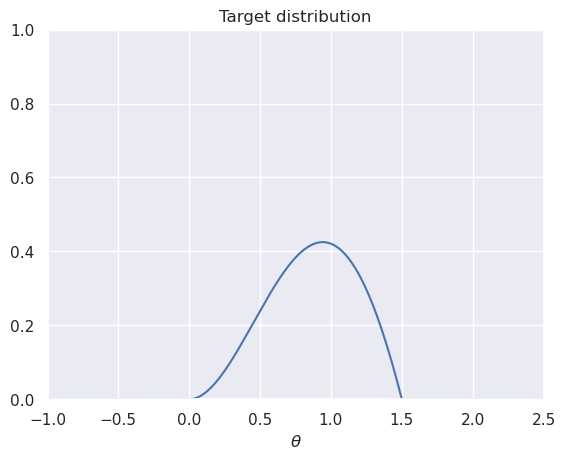

In [5]:
t = np.linspace(-1, 2.5, 500)
def target(t):
    """The unnormalized distribution we want to sample from"""
    return t * (1.5-t) * np.sin(t) * ((t > 0) & (t < 1.5))
plt.figure()
plt.plot(t, target(t))
plt.title('Target distribution')
plt.xlabel(r'$\theta$')
plt.axis([-1,2.5,0,1])
plt.show()

How can we make this look like the geometric example from before? We'll generate samples from a uniform distribution, and throw some away at random (instead of deterministically like in the previous example).

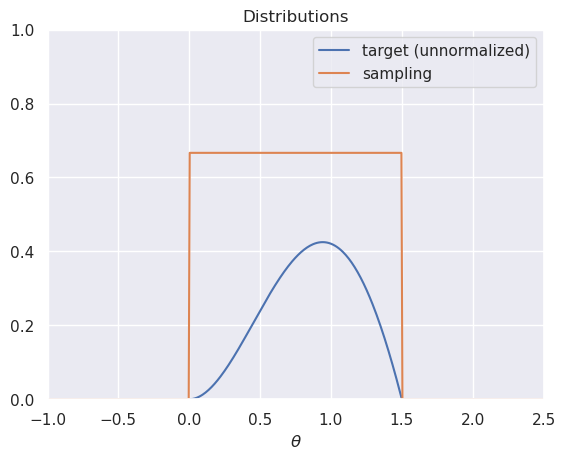

In [6]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(t):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(t, 0, 1.5)

plt.figure()
plt.plot(t, target(t), label='target (unnormalized)')
plt.plot(t, uniform_sampling_dist(t), label='sampling')
plt.axis([-1,2.5,0,1])
plt.legend()
plt.title('Distributions')
plt.xlabel(r'$\theta$')
plt.show()

In [7]:
def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are θ-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # These had better all be between 0 and 1!
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]


Max accept prob: 0.638
Accepted 36436 out of 100000 proposals


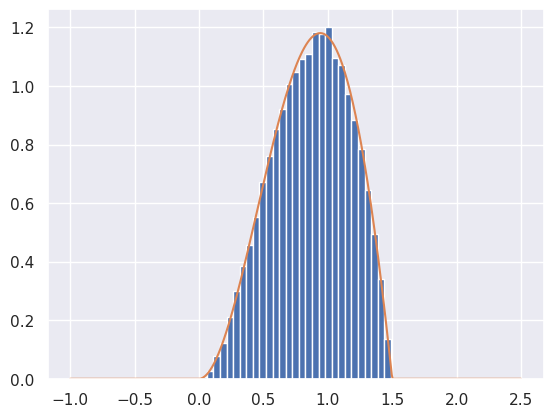

In [8]:
samples = rejection_sample_uniform(num_samples=100000)
plt.figure()
# Plot a true histogram (comparable with density functions) using density=True
plt.hist(samples, bins=np.linspace(-0.5, 2, 50), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
plt.plot(t, target(t) / 0.36)


As a final example, what happens if we want to sample across the entire real line? For instance, suppose our density is $p(\theta|x) \propto \exp(-\theta) |\sin(2\theta)|$ for $\theta \in [0, \infty)$. We certainly can't use a uniform proposal distribution, but using the exponential distribution works just fine.

Accepted 76 out of 100 proposals


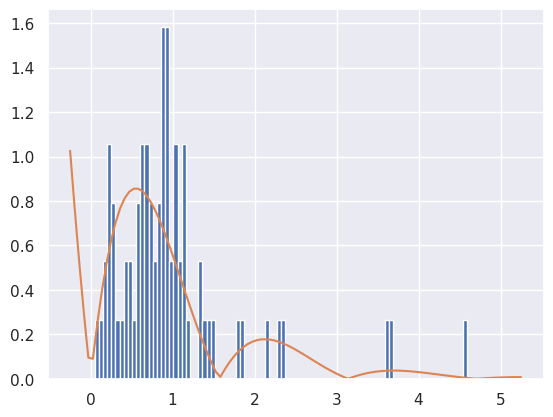

In [9]:
def decaying_target_distribution(t):
    """Unnormalized target distribution as described above"""
    return np.exp(-t) * np.abs(np.sin(2*t))

def sampling_distribution_exponential(t):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of θ=0
    return stats.expon.pdf(t, loc=0, scale=1.0)

def rejection_sample_exponential(num_samples=100):
    proposals = np.random.exponential(scale=1.0, size=num_samples)
    
    accept_probs = decaying_target_distribution(proposals) / sampling_distribution_exponential(proposals)
    accept = np.random.uniform(0, 1, num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]
samples = rejection_sample_exponential(num_samples=100)
plt.figure()
plt.hist(samples, bins=np.linspace(0, 5, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

tmin, tmax, _, _ = plt.axis()
t_inf = np.linspace(tmin, tmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
plt.plot(t_inf, decaying_target_distribution(t_inf) / 0.6)
plt.show()

## Gibbs Sampling

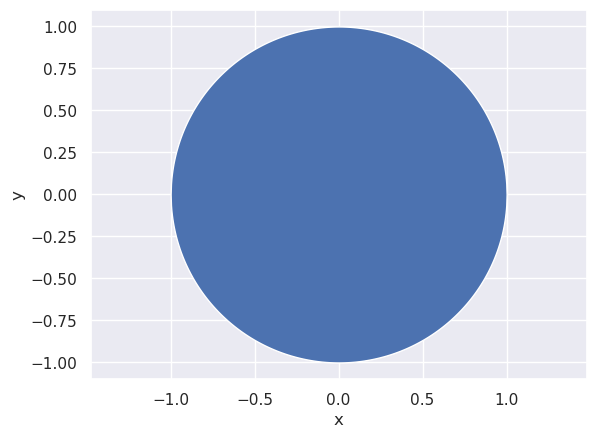

In [10]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.figure()
plt.fill_between(x_, -semicircle, semicircle)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');

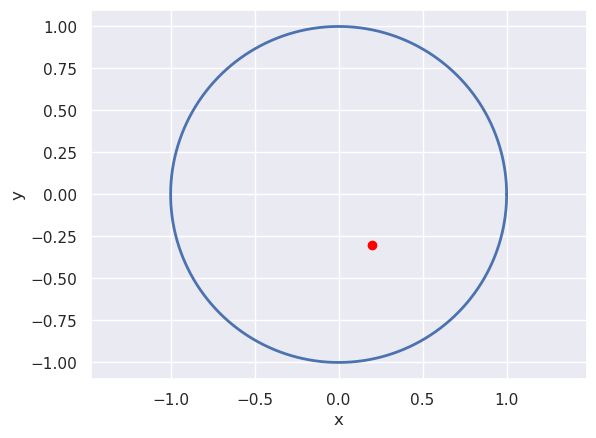

In [11]:
t = np.arange(0, 2 * np.pi, .001)

x_circ = np.cos(t)
y_circ = np.sin(t)

plt.figure()
plt.plot(x_circ, y_circ, lw=2)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
initial_point = np.array([0.2, -0.3])

x_val, y_val = initial_point

plt.scatter(x_val, y_val, color='red')
stage = 'find_x_dist_given_y'
line = None

find_x_dist_given_y


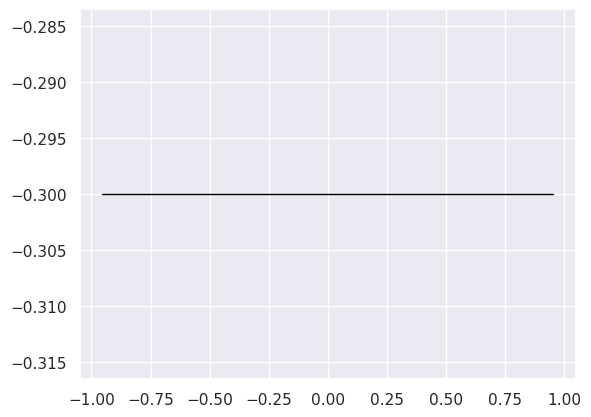

In [12]:
### Interactive demo cell
# Keep running this over and over to generate points on the graph from the
# previous cell. Make sure you're using `%matplotlib notebook`
# Each time you run this cell, the variable `stage` controls which of the
# 4 if/elif blocks executes, and then changes it so that the next block
# will execute next time.

print(stage)
# Draw the horizontal line
if stage == "find_x_dist_given_y":
    if line:
        line.remove()
    x_max = np.sqrt(1 - y_val ** 2)
    x_min = -x_max
    # Draw horizontal line
    line,  = plt.plot([x_min, x_max], [y_val, y_val], color='black', lw=1)
    stage = 'sample_x_given_y'

# Sample a point
elif stage == 'sample_x_given_y':
    plt.scatter(x_val, y_val, color='gray')
    x_val = np.random.uniform(x_min, x_max)
    plt.scatter(x_val, y_val, color='red')
    stage = "find_y_dist_given_x"
    
# Draw the vertical line
elif stage == "find_y_dist_given_x":
    if line:
        line.remove()
    y_max = np.sqrt(1 - x_val ** 2)
    y_min = -y_max
    # Draw vertical line
    line,  = plt.plot([x_val, x_val], [y_min, y_max], color='black', lw=1)
    stage = 'sample_y_given_x'

# Sample a point
elif stage == 'sample_y_given_x':
    plt.scatter(x_val, y_val, color='gray')
    y_val = np.random.uniform(y_min, y_max)
    plt.scatter(x_val, y_val, color='red')
    stage = 'find_x_dist_given_y'
